## Compare if we get more information from which columns


In [6]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
importlib.reload(sys.modules['models.ICA_EM'])
import tqdm
from sklearn.metrics import mean_squared_error as mse

In [2]:
n = 10000
J = 6
I = 5

In [42]:
def percentage_first_column_is_better(treatment_true, treatment_first, treatment_third):
    # requires numpy arrays

    deviation_first = np.abs(treatment_first - treatment_true)
    deviation_third = np.abs(treatment_third - treatment_true)
    return np.sum(deviation_first < deviation_third)/len(deviation_first)
″
    

SyntaxError: invalid character '″' (U+2033) (4244774159.py, line 7)

### No init CausalVarEM



In [19]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []
data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(200)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=None, max_iter = 100, random_seed= i, mode="zeros")
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1,0])
df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_treatment_col": est_treatment_col,
        "est_treatment_confounder_col": est_confounder_col
    }
)
df.to_csv("results/new_order_column_comp_CausalVarEM_no_A_enforce_zeors.csv", index=False)

100%|██████████| 200/200 [1:13:32<00:00, 22.06s/it]


Text(0.5, 0, 'true treatment')

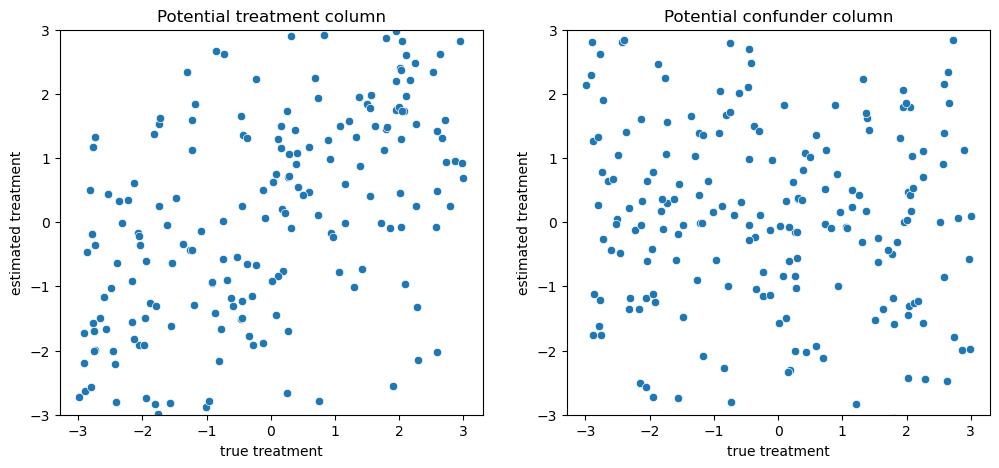

In [8]:
df = pd.read_csv("results/new_order_column_comp_CausalVarEM_no_A.csv")

fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_confounder_col", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")


In [24]:
# root mse
est_treatment_col = df.est_treatment_treatment_col
est_confounder_col = df.est_treatment_confounder_col
print("Root MSE first column", np.sqrt(mse(df.true_treatment, est_treatment_col)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, est_confounder_col)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -est_treatment_col)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- est_confounder_col)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -est_treatment_col))
print("Std of the error third column unnormed", np.std(df.true_treatment -est_confounder_col))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, est_treatment_col,-est_confounder_col))


Root MSE first column 0.9007149805482971
Root MSE third column unnormed 2.380426362246194
Mean absolute error first column 0.6678615852910802
Mean absolute error first column 1.899950313453171
Std of the error first column 0.8987886813654463
Std of the error third column unnormed 2.3733960395484583
Percentage first column is better then unormalized other 0.745


## True A CausalVarEM




In [28]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []

data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=data.mixing_matrix_observed, max_iter = 100,
                      random_seed= i, 
                      mode="zeros")
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1, 0])   

df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_second_last": est_treatment_col,
        "est_treatment_third_unnormed": est_confounder_col
    }
)
df.to_csv("results/new_order_column_comp_CausalVarEM_true_A_zeros_enforced.csv", index=False)
    


100%|██████████| 100/100 [37:47<00:00, 22.67s/it]


Text(0.5, 0, 'true treatment')

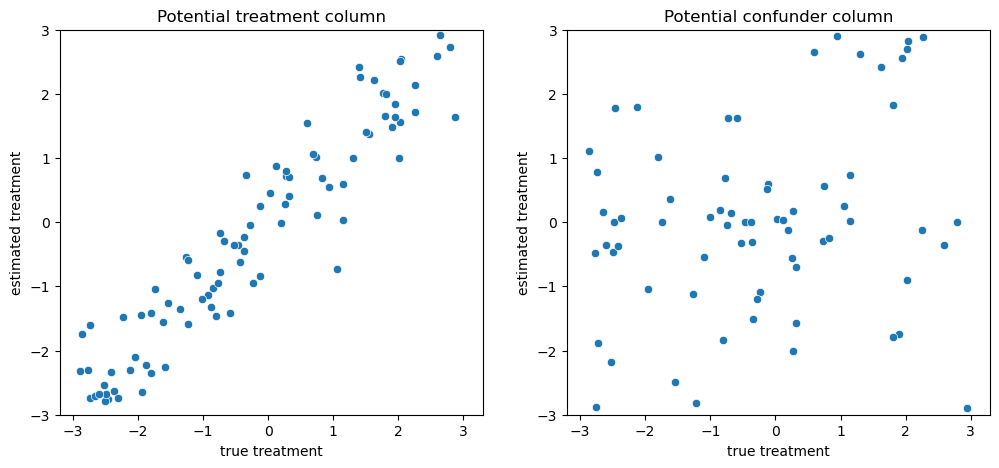

In [29]:
df = pd.read_csv("results/new_order_column_comp_CausalVarEM_true_A_zeros_enforced.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_second_last", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_third_unnormed", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")



In [31]:
# root mse
print("Root MSE first column", np.sqrt(mse(df.true_treatment, df.est_treatment_second_last)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, df.est_treatment_third_unnormed)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -df.est_treatment_second_last)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- df.est_treatment_third_unnormed)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -df.est_treatment_second_last))
print("Std of the error third column unnormed", np.std(df.true_treatment -df.est_treatment_third_unnormed))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, df.est_treatment_second_last,df.est_treatment_third_unnormed))


Root MSE first column 0.5796154878100094
Root MSE third column unnormed 3.7552980151909963
Mean absolute error first column 0.4598781994368791
Mean absolute error first column 2.666545549264259
Std of the error first column 0.5796122350795263
Std of the error third column unnormed 3.7492470077894082
Percentage first column is better then unormalized other 0.89


## VarEM

In [15]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []
data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n,I, J, random_state=i)
    est = VarEM(update_sigma=False, true_A=None, max_iter = 100, random_seed= i)
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1,0]) 
df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_treatment_col": est_treatment_col,
        "est_treatment_confounder_col": est_confounder_col
    }
)
df.to_csv("results/new_order_column_comp_Var_no_A.csv", index=False)

100%|██████████| 100/100 [38:23<00:00, 23.03s/it]


Text(0.5, 0, 'true treatment')

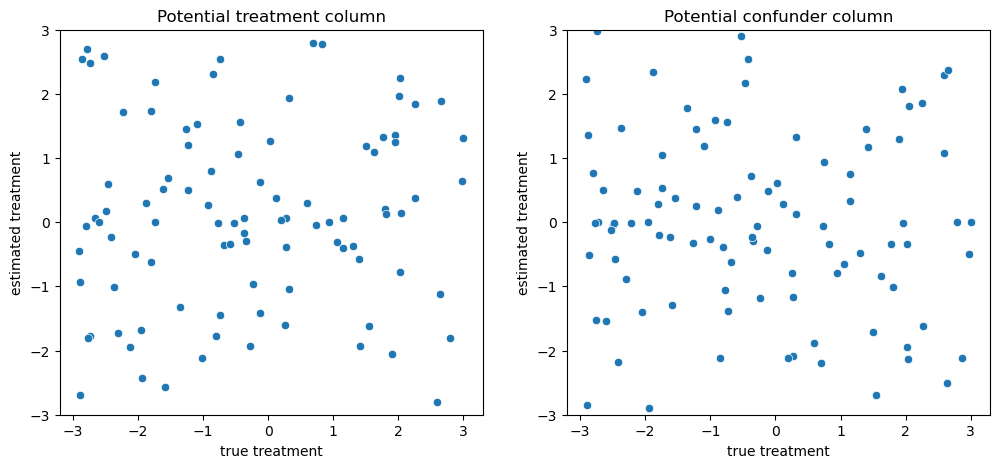

In [17]:
df = pd.read_csv("results/new_order_column_comp_Var_no_A.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_confounder_col", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")


In [19]:
# root mse
est_treatment_col = df.est_treatment_treatment_col
est_confounder_col = df.est_treatment_confounder_col
print("Root MSE first column", np.sqrt(mse(df.true_treatment, est_treatment_col)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, est_confounder_col)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -est_treatment_col)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- est_confounder_col)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -est_treatment_col))
print("Std of the error third column unnormed", np.std(df.true_treatment -est_confounder_col))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, est_treatment_col, -est_confounder_col))


Root MSE first column 2.459642642478975
Root MSE third column unnormed 2.3459571183147343
Mean absolute error first column 1.8920622933322344
Mean absolute error first column 1.8781101039974675
Std of the error first column 2.4558259158325577
Std of the error third column unnormed 2.338927783901715
Percentage first column is better then unormalized other 0.46
